Get the data from the repo -> anonymize!

In [1]:
!git clone https://github.com/tbaeumel/transformer-digit-arithmetic.git

Cloning into 'transformer-digit-arithmetic'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 4), reused 36 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 24.95 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:

%cd transformer-digit-arithmetic

/content/transformer-digit-arithmetic


Get pyvene
Olmo2 was not in pyvene - i wrote an extension so that olmo2 can be an intervenable model.
 has to be anonymized

In [3]:
# pip uninstall -y pyvene  # pyvene has to be uninstalled if a standard version is currently installed
# pip install pyvene
!pip install git+https://github.com/tbaeumel/pyvene

  Cloning https://github.com/tbaeumel/pyvene to /tmp/pip-req-build-06r6hkx3
  Running command git clone --filter=blob:none --quiet https://github.com/tbaeumel/pyvene /tmp/pip-req-build-06r6hkx3
  Resolved https://github.com/tbaeumel/pyvene to commit e9085b6d207d5790146921d02a8af4859406c9ea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━

In [5]:
import pyvene as pv
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import sys
import torch.nn.functional as F
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    ZeroIntervention,
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from huggingface_hub import login
import re
import numpy
from tqdm import tqdm
from matplotlib import pyplot as plt
import transformers
import os

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


## Load model

Llama 70B wont work on colab

llama 8b and olmo 2 7b will work on l4 or a100

people have to login with their huggingface key to get access to the llama models


In [ ]:
# Login to Huggingface to get access to model parameters
# Paste your token here
login('')

In [9]:
# choose your model
model = "Llama-3-8B" # Llama-3-70B # Olmo-2-7B

In [6]:
models = {"Llama-3-8B": "meta-llama/Meta-Llama-3-8B", "Llama-3-70B": "meta-llama/Meta-Llama-3-70B", "Olmo-2-7B": "allenai/OLMo-2-1124-7B" }

# Set parameters
params = {
    'model_name': models[model],
    'device': "cuda" if torch.cuda.is_available() else "cpu"
}

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(params['model_name'])
model = AutoModelForCausalLM.from_pretrained(params['model_name'], torch_dtype=torch.float16).to(params['device'])

# Confirm device
print(f"Using device: {params['device']}")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
  print("Using GPU")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

Using device: cuda
Using GPU


## Load the Data

In [8]:
# Load the JSON file
input_file = "Intervention_Data/intervention_data_addition_op1.json"
with open(input_file, "r") as f:
    data = json.load(f)


# Digit circuit Intervention



Choose:
- thresholds
- digit position
- task (operator)
- operand (which intervention dataset)

this can be changed to standard values for the thresholds and layers (see paper Section X), so that based on model and digti position the best threshold is chosen

In [10]:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# labels
labels = ["hundredth", "tenth", "unit"]
# task (operator)
task = "addition" # "subtraction"
# which oeprand
operand = "op1" # "op2"

In [11]:
# layer sets to intervene on based on model, task, and operand
# TODO do this elegantly

key = f"{model}_{task}_{operand}"

layer_sets = {
    "Llama-3-8B_addition_op1": [16, 17, 18, 19, 20, 21, 22, 23, 24],
    "Llama-3-8B_addition_op2": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    "Llama-3-8B_subtraction_op1": [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    "Llama-3-8B_subtraction_op2": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    "Llama-3-70B_addition_op1": [39, ..., 56],
    "Llama-3-70B_addition_op2": [39, ..., 56],
    "Llama-3-70B_subtraction_op1": [39, ..., 58],
    "Llama-3-70B_subtraction_op2": [39, ..., 58],
    "Olmo-2-7B_addition_op1": [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    "Olmo-2-7B_addition_op2": [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    "Olmo-2-7B_subtraction_op1": [19, 20, 21, 22, 23, 24, 25, 26, 27],
    "Olmo-2-7B_subtraction_op2": [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
    }

layer_set = layer_sets[key]

In [ ]:
##############################################################
# Define the set of layers and their corresponding subspaces #
##############################################################

for label in labels:
  for threshold in thresholds:
    folder_path = f"{model}_subtraction_op1op2_threshold/{threshold}"

    # Dictionary to store extracted subspaces
    layer_subspaces_map = {}

    # List all files in the directory
    for filename in os.listdir(folder_path):
        if filename.startswith("fisher_") and filename.endswith(".json"):
            # Extract layer number from filename
            layer_number = int(filename.split("_")[-1].split(".")[0])  # Extracts the number at the end

            # Open and read the JSON file
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r") as file:
                data_1 = json.load(file)

                # Extract the top k dimensions under "unit"
                top_dimensions = list(data_1["digit_types"][label]["indices"])
                layer_subspaces_map[layer_number] = top_dimensions

    # Define the specific layer combinations you want to intervene at
    layer_combinations = [
        [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
    ]


    ################################################
    # Perform all interventions on each data point #
    ################################################

    # Iterate through each query in the dataset
    for j, entry in enumerate(data):
        data_entry = []
        model_layers = model.config.num_hidden_layers
        window_size = 1

        sentence = entry["one_shot_base"]
        sentence_intervention = entry["one_shot_source1"]

        base = tokenizer(sentence, return_tensors="pt").to(device)

        # Number of tokens
        tokenized_input = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True)
        input_ids = tokenized_input["input_ids"].to(device)
        num_tokens = input_ids.shape[1]

        ############################
        # Clean Run for comparison #
        ############################

        inputs = [tokenizer(sentence, return_tensors="pt").to(device),]
        res = model(**inputs[0])

        distrib = res.logits
        logits = distrib[0][-1]

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the top 10 tokens and their probabilities
        top_k = 50
        top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

        # Convert indices to tokens
        top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

        # Collect the data
        data_temp = []
        for token, prob in zip(top_k_tokens, top_k_probs):
            data_temp.append({
                "token": token,
                "prob": prob.detach().cpu().item()
            })

        data_entry.append({"layer": "clean", "pos": "-1", "top_100": data_temp})

        ###############################################
        # Interchange Interventions across layer sets #
        ###############################################

        # Get the index of the last token using len()
        last_token_index = len(base['input_ids'][0]) - 1  # Use len() to get the length of the sequence

        # Iterate over each layer combination
        for layer_set in tqdm(layer_combinations):

            pos_i = last_token_index

            # Create intervention for specific layers
            config = pv.IntervenableConfig([{
                "layer": l,
                "component": "mlp_output",
                "intervention_type": VanillaIntervention
                } for l in layer_set] # Pass a list instead of a single layer
            )

            pv_model = pv.IntervenableModel(config, model=model)

            # Define list of subspaces based on the layer_subspaces_map
            # Create an empty list to store the corresponding subspaces for each layer in layer_set
            subspaces = []

            # Loop over the layers in the current layer_set and fetch corresponding subspaces
            for layer in layer_set:
                subspaces.append(layer_subspaces_map[layer])

            # run an interchange intervention
            _, intervened_outputs = pv_model(
              # the base input
              base=tokenizer(sentence, return_tensors = "pt").to(device),
              # the source input
              sources=tokenizer(sentence_intervention, return_tensors = "pt").to(device),
              # the location to intervene at (last token)
              unit_locations={"sources->base": pos_i},
              subspaces = subspaces
            )


            distrib = intervened_outputs.logits
            logits = distrib[0][-1]

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=-1)

            # Get the top 10 tokens and their probabilities
            top_k = 100
            top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

            # Convert indices to tokens
            top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

            # Collect the data
            data_temp = []
            for token, prob in zip(top_k_tokens, top_k_probs):
                data_temp.append({
                    "token": token,
                    "prob": prob.detach().cpu().item()
                })

            data_entry.append({"layer": layer_set, "pos": pos_i, "top_100": data_temp})

        df = pd.DataFrame(data_entry)

        output_dir = f"Subtraction_Llama8B_Threshold/Op2/{label}/{threshold}"
        os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

        df.to_csv(f"{output_dir}/ii_op2_mlp_fisherop1op2__no_carry_{label}_threshold_{threshold}_{j}_llama38B.csv")
        #df.to_csv(f"Addition_Llama8B_Threshold/Op2_28/{label}/{threshold}/ii_op2_mlp_fisherop1op2__no_carry_{label}_threshold_{threshold}_{j}_llama3-8.csv")

        print("Finished Calculating")

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

Finished Calculating


# Operand 1 Intervention

In [ ]:
##############################################################
# Define the set of layers and their corresponding subspaces #
##############################################################

# Path to the folder containing the JSON files
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# labels
labels = ["tenth", "unit", "hundredth"]

for label in labels:
  for threshold in thresholds:
    folder_path = f"fisher_llama8B_subtraction_op1op2_threshold/{threshold}"
    # folder_path = f"fisher_llama8B_addition_op1op2_threshold/{threshold}"

    # Dictionary to store extracted subspaces
    layer_subspaces_map = {}

    # List all files in the directory
    for filename in os.listdir(folder_path):
        if filename.startswith("fisher_") and filename.endswith(".json"):
            # Extract layer number from filename
            layer_number = int(filename.split("_")[-1].split(".")[0])  # Extracts the number at the end

            # Open and read the JSON file
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r") as file:
                data_1 = json.load(file)

                # Extract the top k dimensions under "unit"
                top_dimensions = list(data_1["digit_types"][label]["indices"])
                layer_subspaces_map[layer_number] = top_dimensions

    # Define the specific layer combinations you want to intervene at
    layer_combinations = [
        [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28] # Llama8
        # [19, 20, 21, 22, 23, 24, 25, 26, 27] # Olmo2
    ]


    ################################################
    # Perform all interventions on each data point #
    ################################################

    # Iterate through each query in the dataset
    for j, entry in enumerate(data):
        data_entry = []
        model_layers = model.config.num_hidden_layers
        window_size = 1

        sentence = entry["one_shot_base"]
        sentence_intervention = entry["one_shot_source2"] # CHANGE

        base = tokenizer(sentence, return_tensors="pt").to(device)

        # Number of tokens
        tokenized_input = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True)
        input_ids = tokenized_input["input_ids"].to(device)
        num_tokens = input_ids.shape[1]

        ############################
        # Clean Run for comparison #
        ############################

        inputs = [tokenizer(sentence, return_tensors="pt").to(device),]
        res = model(**inputs[0])

        distrib = res.logits
        logits = distrib[0][-1]

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the top 10 tokens and their probabilities
        top_k = 50
        top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

        # Convert indices to tokens
        top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

        # Collect the data
        data_temp = []
        for token, prob in zip(top_k_tokens, top_k_probs):
            data_temp.append({
                "token": token,
                "prob": prob.detach().cpu().item()
            })

        data_entry.append({"layer": "clean", "pos": "-1", "top_100": data_temp})

        ###############################################
        # Interchange Interventions across layer sets #
        ###############################################

        # Get the index of the last token using len()
        last_token_index = len(base['input_ids'][0]) - 1  # Use len() to get the length of the sequence

        # Iterate over each layer combination
        for layer_set in tqdm(layer_combinations):

            pos_i = last_token_index

            # Create intervention for specific layers
            config = pv.IntervenableConfig([{
                "layer": l,
                "component": "mlp_output",
                "intervention_type": VanillaIntervention
                } for l in layer_set] # Pass a list instead of a single layer
            )

            pv_model = pv.IntervenableModel(config, model=model)

            # Define list of subspaces based on the layer_subspaces_map
            # Create an empty list to store the corresponding subspaces for each layer in layer_set
            subspaces = []

            # Loop over the layers in the current layer_set and fetch corresponding subspaces
            for layer in layer_set:
                subspaces.append(layer_subspaces_map[layer])

            # run an interchange intervention
            _, intervened_outputs = pv_model(
              # the base input
              base=tokenizer(sentence, return_tensors = "pt").to(device),
              # the source input
              sources=tokenizer(sentence_intervention, return_tensors = "pt").to(device),
              # the location to intervene at (last token)
              unit_locations={"sources->base": pos_i},
              subspaces = subspaces
            )


            distrib = intervened_outputs.logits
            logits = distrib[0][-1]

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=-1)

            # Get the top 10 tokens and their probabilities
            top_k = 100
            top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

            # Convert indices to tokens
            top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

            # Collect the data
            data_temp = []
            for token, prob in zip(top_k_tokens, top_k_probs):
                data_temp.append({
                    "token": token,
                    "prob": prob.detach().cpu().item()
                })

            data_entry.append({"layer": layer_set, "pos": pos_i, "top_100": data_temp})

        df = pd.DataFrame(data_entry)

        output_dir = f"Subtraction_Llama8B_Threshold/Op1/{label}/{threshold}"
        # output_dir = f"Addition_Llama8B_Threshold/Op1_24/{label}/{threshold}"
        os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

        df.to_csv(f"{output_dir}/ii_op1_mlp_fisherop1op2__no_carry_{label}_threshold_{threshold}_{j}_llama8.csv")
        # df.to_csv(f"{output_dir}/ii_op1_mlp_fisherop1op2__no_carry_{label}_threshold_{threshold}_{j}_llama8.csv")
        #df.to_csv(f"Addition_Llama8B_Threshold/Op2_28/{label}/{threshold}/ii_op2_mlp_fisherop1op2__no_carry_{label}_threshold_{threshold}_{j}_llama3-8.csv")

        print("Finished Calculating")

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Finished Calculating


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Finished Calculating


# Evaluation

In [ ]:
import os
import json
import pandas as pd
import ast
import re

# Load the dataset
with open("intervention_data_sub_one-shot_no_carry.json", "r") as f:
    dataset = json.load(f)

# Root folder containing all intervention subfolders
# root_folder = "Llama_subspace_op2_fisherop1op2/unit/"
# root_folder = "Addition_Llama8B_Threshold/Op1_24/unit/"
root_folder = "Subtraction_Llama8B_Threshold/Op2/hundredth/"
variant_labels = ["bbb", "bbs", "bsb", "bss", "sbb", "sbs", "ssb", "sss"]

# Loop through all subdirectories
for subfolder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, subfolder_name)

    # Make sure it's a directory
    if os.path.isdir(folder_path):
        print(f"Processing: {folder_path}")
        # Place your existing code here, using `folder_path`

    subfolder_results = {}

    # Get all relevant CSV files and sort them by extracted index
    csv_files = [f for f in os.listdir(folder_path) if re.match(r"ii_.*_(\d+)_llama38B\.csv", f)]
    # csv_files = [f for f in os.listdir(folder_path) if re.match(r"ii_.*_(\d+)_llama3-8\.csv", f)]
    # csv_files = [f for f in os.listdir(folder_path) if re.match(r"ii_.*_(\d+)_olmo2\.csv", f)]
    print(len(csv_files))
    csv_files.sort(key=lambda x: int(re.search(r"_(\d+)_llama38B", x).group(1)))
    #print(csv_files[0])

    # Process each file in the folder (corresponds to dataset entries)
    for file_name in csv_files:
        match = re.search(r"_(\d+)_llama38B", file_name)
        if not match:
            continue
        i = int(match.group(1))  # Extract index from filename
        print(i)

        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        # file_path = os.path.normpath(os.path.join(folder_path, file_name))
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                first_line = f.readline()
        except Exception as e:
            print(f"❌ Could not open file: {file_path}")
            print(f"   Error: {e}")
            continue
        df = pd.read_csv(file_path)

        # Get alt_source2_variants for the corresponding dataset entry
        alt_tokens = list(map(str, dataset[i]["alt_source1_variants"]))

        # Extract probabilities for matching tokens per layer
        for _, row in df.iterrows():
            layer = row["layer"]  # Extract layer number
            if layer not in subfolder_results:
                subfolder_results[layer] = {label: [] for label in variant_labels}

            token_probs = ast.literal_eval(row["top_100"])  # Convert string to list

            for variant_label, token in zip(variant_labels, alt_tokens):
                for entry in token_probs:
                    if entry["token"] == token:
                        subfolder_results[layer][variant_label].append(entry["prob"])

    # Compute overall average per layer per variant label
    results = {
        layer: {
            label: sum(probs) / len(probs) if probs else 0
            for label, probs in subfolder_results[layer].items()
        }
        for layer in subfolder_results
    }

    # Store results in individual JSON files per subfolder
    safe_folder_name = folder_path.replace("/", "_")
    output_file = f"ii_{safe_folder_name}.json"
    # output_file = f"ii_{folder_path}.json"
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

Processing: Subtraction_Llama8B_Threshold/Op2/hundredth/0.4
200
0
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_0_llama38B.csv
1
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_1_llama38B.csv
2
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_2_llama38B.csv
3
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_3_llama38B.csv
4
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_4_llama38B.csv
5
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_5_llama38B.csv
6
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__no_carry_hundredth_threshold_0.4_6_llama38B.csv
7
Subtraction_Llama8B_Threshold/Op2/hundredth/0.4/ii_op2_mlp_fisherop1op2__

##Visualization

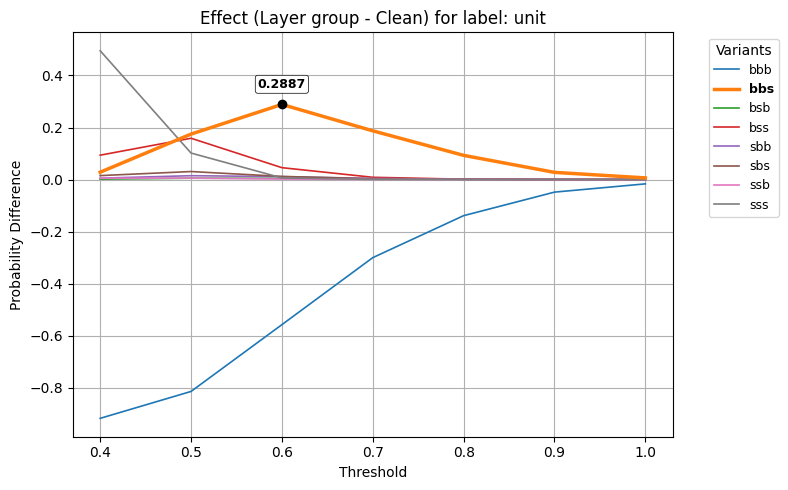

Saved plot for unit at Subtraction_Llama8B_Threshold/Op1/Results/effect_unit.png


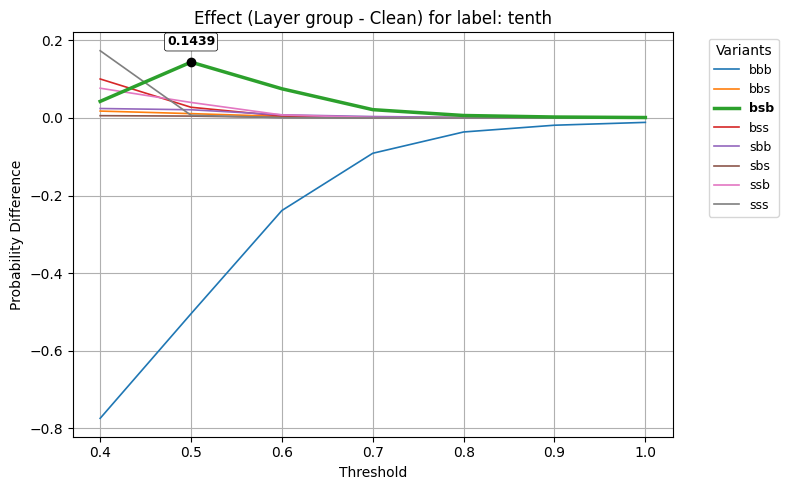

Saved plot for tenth at Subtraction_Llama8B_Threshold/Op1/Results/effect_tenth.png


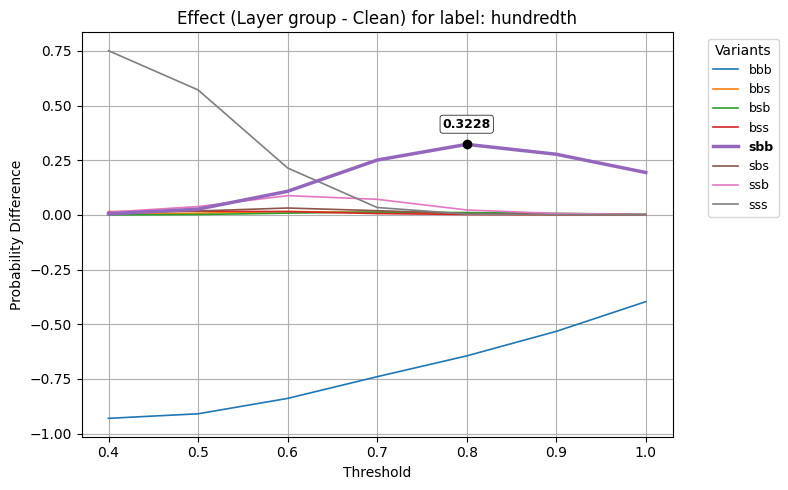

Saved plot for hundredth at Subtraction_Llama8B_Threshold/Op1/Results/effect_hundredth.png


In [ ]:
import json
import os
import re
import matplotlib.pyplot as plt

folder = "Subtraction_Llama8B_Threshold/Op1/Results/"  # change to your folder path


labels = ["unit", "tenth", "hundredth"]
variants = ["bbb", "bbs", "bsb", "bss", "sbb", "sbs", "ssb", "sss"]
key_clean = "clean"
# key_layers = "[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
key_layers = "[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]"

# Structure: data[label][variant] = list of (threshold, effect)
data = {label: {v: [] for v in variants} for label in labels}

# Load and compute effect (layer group prob - clean prob) for each file
for fname in os.listdir(folder):
    match = re.match(r"ii_Subtraction_Llama8B_Threshold_Op1_(\w+)_(\d*\.?\d+)\.json", fname)
    if not match:
        continue
    label, threshold_str = match.groups()
    if label not in labels:
        continue
    threshold = float(threshold_str)

    with open(os.path.join(folder, fname), "r") as f:
        content = json.load(f)

        if key_clean not in content or key_layers not in content:
            continue

        clean_probs = content[key_clean]
        layer_probs = content[key_layers]

        for v in variants:
            clean_val = clean_probs.get(v, 0)
            layer_val = layer_probs.get(v, 0)
            effect = layer_val - clean_val
            data[label][v].append((threshold, effect))

# Sort by threshold
for label in labels:
    for v in variants:
        data[label][v].sort(key=lambda x: x[0])

# Plotting effect for all labels and variants, saving to files
focus_variant_map = {
    "unit": "bbs",
    "tenth": "bsb",
    "hundredth": "sbb"
}

for label in labels:
    plt.figure(figsize=(8, 5))
    plt.title(f"Effect (Layer group - Clean) for label: {label}")

    for v in variants:
        thresh = [t for t, _ in data[label][v]]
        effects = [e for _, e in data[label][v]]

        is_focus = v == focus_variant_map[label]
        line_style = {
            "linewidth": 2.5 if is_focus else 1.2,
            "label": f"**{v}**" if is_focus else v,
            "zorder": 3 if is_focus else 2,
        }
        plt.plot(thresh, effects, **line_style)

        # Highlight and annotate maximum for focus variant
        if is_focus and effects:
            max_idx = max(range(len(effects)), key=lambda i: effects[i])
            max_thresh = thresh[max_idx]
            max_effect = effects[max_idx]

            plt.plot(max_thresh, max_effect, marker="o", color="black", zorder=5)
            plt.annotate(
                f"{max_effect:.4f}",
                (max_thresh, max_effect),
                textcoords="offset points",
                xytext=(0, 12),  # Adjust offset further above
                ha='center',
                fontsize=9,
                fontweight='bold',
                color="black",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5)
            )

    plt.xlabel("Threshold")
    plt.ylabel("Probability Difference")
    plt.grid(True)

    # Update legend: make focus variant bold
    handles, labels_ = plt.gca().get_legend_handles_labels()
    updated_labels = []
    for l in labels_:
        updated_labels.append(l.replace("**", ""))  # clean label for display
    legend = plt.legend(
        handles,
        updated_labels,
        title="Variants",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=9,
        title_fontsize=10
    )

    # Bold the legend text for the focus variant
    for text_obj, l in zip(legend.get_texts(), labels_):
        if "**" in l:
            text_obj.set_fontweight('bold')

    plt.tight_layout()

    save_path = os.path.join(folder, f"effect_{label}.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Saved plot for {label} at {save_path}")


## Compute Flip Rate

In [ ]:
import os
import ast
import json
import pandas as pd
import os
import json
import pandas as pd
import ast
import re
import sys

# === CONFIGURATION ===
output_folder = "Addition_Olmo2_Threshold/Op1_30/"
root_folder = "Addition_Olmo2_Threshold/Op1_30/unit/"
variant_labels = ["bbb", "bbs", "bsb", "bss", "sbb", "sbs", "ssb", "sss"]
labels = ["unit", "tenth", "hundredth"]
expected_variant_map = {
    "unit": "bbs",
    "tenth": "bsb",
    "hundredth": "sbb"
}

# Load the dataset
with open("intervention_data_one-shot_no_carry.json", "r") as f:
    dataset = json.load(f)

results = {}  # Initialize results dictionary

# Loop through all subdirectories
for subfolder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, subfolder_name)

    # Make sure it's a directory
    if os.path.isdir(folder_path):
        print(f"Processing: {folder_path}")
        # Place your existing code here, using `folder_path`

    subfolder_results = {}

    # Get all relevant CSV files and sort them by extracted index
    csv_files = [f for f in os.listdir(folder_path) if re.match(r"ii_.*_(\d+)_olmo2\.csv", f)]
    csv_files.sort(key=lambda x: int(re.search(r"_(\d+)_olmo2", x).group(1)))

    # Process each file in the folder (corresponds to dataset entries)
    for file_name in csv_files:
        match = re.search(r"_(\d+)_olmo2", file_name)
        if not match:
            continue
        i = int(match.group(1))  # Extract index from filename

        file_path = os.path.join(folder_path, file_name)
        # file_path = os.path.normpath(os.path.join(folder_path, file_name))
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                first_line = f.readline()
        except Exception as e:
            print(f"❌ Could not open file: {file_path}")
            print(f"   Error: {e}")
            continue
        df = pd.read_csv(file_path)

        # Get alt_source2_variants for the corresponding dataset entry
        alt_tokens = list(map(str, dataset[i]["alt_source2_variants"]))

        # Extract probabilities for matching tokens per layer
        for _, row in df.iterrows():
            layer = row["layer"]  # Extract layer number
            if layer not in subfolder_results:
                subfolder_results[layer] = {label: 0 for label in variant_labels}
            token_probs = ast.literal_eval(row["top_100"])  # Convert string to list
            top_token = token_probs[0]["token"]

            for variant_label, token in zip(variant_labels, alt_tokens):
                if top_token == token:
                    subfolder_results[layer][variant_label] += 1
    print(subfolder_results)

    results[subfolder_name] = subfolder_results

# Store results in individual JSON files per subfolder
safe_folder_name = root_folder.replace("/", "_")
output_file = os.path.join(output_folder, f"flip_rate_{safe_folder_name}.json")
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)

Processing: Addition_Olmo2_Threshold/Op1_30/unit/0.4
{'clean': {'bbb': 198, 'bbs': 0, 'bsb': 0, 'bss': 0, 'sbb': 0, 'sbs': 0, 'ssb': 0, 'sss': 0}, '[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]': {'bbb': 17, 'bbs': 101, 'bsb': 0, 'bss': 13, 'sbb': 5, 'sbs': 8, 'ssb': 1, 'sss': 4}}
Processing: Addition_Olmo2_Threshold/Op1_30/unit/0.5
{'clean': {'bbb': 198, 'bbs': 0, 'bsb': 0, 'bss': 0, 'sbb': 0, 'sbs': 0, 'ssb': 0, 'sss': 0}, '[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]': {'bbb': 110, 'bbs': 70, 'bsb': 1, 'bss': 2, 'sbb': 1, 'sbs': 0, 'ssb': 0, 'sss': 0}}
Processing: Addition_Olmo2_Threshold/Op1_30/unit/0.6
{'clean': {'bbb': 198, 'bbs': 0, 'bsb': 0, 'bss': 0, 'sbb': 0, 'sbs': 0, 'ssb': 0, 'sss': 0}, '[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]': {'bbb': 170, 'bbs': 18, 'bsb': 0, 'bss': 0, 'sbb': 0, 'sbs': 0, 'ssb': 0, 'sss': 0}}
Processing: Addition_Olmo2_Threshold/Op1_30/unit/0.7
{'clean': {'bbb': 198, 'bbs': 0, 'bsb': 0, 'bss': 0, 'sbb': 0, 'sbs': 